In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, pairwise_distances
from sklearn.metrics import confusion_matrix
from collections import OrderedDict
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
pd.options.mode.chained_assignment = None

df = pd.read_csv('/content/drive/MyDrive/df.csv')
df.head()

,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged,name,location,...,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,mnr,rl,rd,Maximum Content Similarity
0,GtwU21YOQn-wf4vWRUIx6w,bNYesZ944s6IJVowOnB0iA,pbEiXam9YJL3neCYHGwLUA,9/22/2012,5,0,unlike next we d eaten previous night dish com...,N,Scott E.,"Glengary, WV",...,5,5,2,0,1,4.5,0.083333,497,0.125,0.123653
1,0LpVTc3,TRKxLC3y-ZvP45e5iilMtw,pbEiXam9YJL3neCYHGwLUA,9/22/2012,5,0,probably one best meals i ve ever it s perform...,N,Jerry K.,"Palos Verdes Peninsula, CA",...,0,0,0,0,0,4.5,0.083333,41,0.125,0.000000
2,tljtLzf68Fkwf,0EMm8umAqXZzyhxNpL4M9g,pbEiXam9YJL3neCYHGwLUA,9/19/2012,3,2,service impeccable experience presentation coo...,N,Patricia M.,"Chicago, IL",...,0,1,0,0,0,4.5,0.083333,27,0.375,0.000000
3,iSN,DlwexC7z88ymAzu45skODw,pbEiXam9YJL3neCYHGwLUA,09-06-2012,3,8,the problem places like this given exhorbitant...,N,Terry N.,"San Jose, CA",...,8,6,6,11,0,4.5,0.083333,244,0.375,0.000000
4,Jmwrh7,kW2dk1CWihmh3g7k9N2G8A,pbEiXam9YJL3neCYHGwLUA,09-09-2012,5,1,i idea write review dining alinea brings whole...,N,Shradha Vegetarianista A.,"Chicago, IL",...,679,417,283,22,70,4.5,0.083333,97,0.125,0.760866


In [4]:
def data_cleaning(df):
    print("Cleaning Data")
    # Removing \n from date field
    for i in range(len(df['date'])):
        if df['date'][i][0] == '\n':
            df['date'][i] = df['date'][i][1:]

    # Making yelpJoinDate Format Uniform
    df['yelpJoinDate'] = df['yelpJoinDate'].apply(
        lambda x: datetime.strftime(datetime.strptime(x, '%B %Y'), '01/%m/%Y'))

    # Removing emtpy cells
    if len(np.where(pd.isnull(df))) > 2:
        # TODO
        pass

    # Pre-processing Text Reviews
    # Remove Stop Words
    stop = stopwords.words('english')
    df['reviewContent'] = df['reviewContent'].apply(
        lambda x: ' '.join(word for word in x.split() if word not in stop))

    # Remove Punctuations
    tokenizer = RegexpTokenizer(r'\w+')
    df['reviewContent'] = df['reviewContent'].apply(
        lambda x: ' '.join(word for word in tokenizer.tokenize(x)))

    # Lowercase Words
    df['reviewContent'] = df['reviewContent'].apply(
        lambda x: x.lower())
    print("Data Cleaning Complete")
    return df


In [5]:
def feature_engineering(df):
    print("Feature Engineering: Creating New Features")
    # Maximum Number of Reviews per day per reviewer
    mnr_df1 = df[['reviewerID', 'date']].copy()
    mnr_df2 = mnr_df1.groupby(by=['date', 'reviewerID']).size().reset_index(name='mnr')
    mnr_df2['mnr'] = mnr_df2['mnr'] / mnr_df2['mnr'].max()
    df = df.merge(mnr_df2, on=['reviewerID', 'date'], how='inner')

    # Review Length
    df['rl'] = df['reviewContent'].apply(
        lambda x: len(x.split()))

    # Review Deviation
    df['rd'] = abs(df['rating'] - df['restaurantRating']) / 4

    # Maximum cosine similarity
    review_data = df

    res = OrderedDict()

    # Iterate over data and create groups of reviewers
    for row in review_data.iterrows():
        if row[1].reviewerID in res:
            res[row[1].reviewerID].append(row[1].reviewContent)
        else:
            res[row[1].reviewerID] = [row[1].reviewContent]

    individual_reviewer = [{'reviewerID': k, 'reviewContent': v} for k, v in res.items()]
    df2 = dict()
    df2['reviewerID'] = pd.Series([])
    df2['Maximum Content Similarity'] = pd.Series([])
    vector = TfidfVectorizer(min_df=0)
    count = -1
    for reviewer_data in individual_reviewer:
        count = count + 1
        # Handle Null/single review gracefully -24-Apr-2019
        try:
            tfidf = vector.fit_transform(reviewer_data['reviewContent'])
        except:
            pass
        cosine = 1 - pairwise_distances(tfidf, metric='cosine')

        np.fill_diagonal(cosine, -np.inf)
        max = cosine.max()

        # To handle reviewier with just 1 review
        if max == -np.inf:
            max = 0
        df2['reviewerID'][count] = reviewer_data['reviewerID']
        df2['Maximum Content Similarity'][count] = max

    df3 = pd.DataFrame(df2, columns=['reviewerID', 'Maximum Content Similarity'])

    # left outer join on original datamatrix and cosine dataframe -24-Apr-2019
    df = pd.merge(review_data, df3, on="reviewerID", how="left")

    df.drop(index=np.where(pd.isnull(df))[0], axis=0, inplace=True)
    print("Feature Engineering Complete")
    return df


In [6]:
def under_sampling(df):
    print("Under-Sampling Data")
    # Count of Reviews
    # print("Authentic", len(df[(df['flagged'] == 'N')]))
    # print("Fake", len(df[(df['flagged'] == 'Y')]))

    sample_size = len(df[(df['flagged'] == 'Y')])

    authentic_reviews_df = df[df['flagged'] == 'N']
    fake_reviews_df = df[df['flagged'] == 'Y']

    authentic_reviews_us_df = authentic_reviews_df.sample(sample_size)
    under_sampled_df = pd.concat([authentic_reviews_us_df, fake_reviews_df], axis=0)

    # print("Under-Sampled Fake", len(under_sampled_df[(under_sampled_df['flagged'] == 'Y')]))
    # print("Under-Sampled Authentic", len(under_sampled_df[(under_sampled_df['flagged'] == 'N')]))

    # Graph of Data Distribution
    # fig, ax = plt.subplots(figsize=(6, 4))
    # sns.countplot(x='flagged', data=under_sampled_df)
    # plt.title("Count of Reviews")
    # plt.show()
    print("Under-Sampling Complete")
    return under_sampled_df


In [7]:
def semi_supervised_learning(df, model, algorithm, threshold=0.8, iterations=40):
    df = df.copy()
    print("Training "+algorithm+" Model")
    labels = df['flagged']

    df.drop(['reviewID', 'reviewerID', 'restaurantID', 'date', 'name', 'location', 'yelpJoinDate', 'flagged',
             'reviewContent', 'restaurantRating'], axis=1, inplace=True)

    train_data, test_data, train_label, test_label = train_test_split(df, labels, test_size=0.25, random_state=42)

    test_data_copy = test_data.copy()
    test_label_copy = test_label.copy()

    all_labeled = False

    current_iteration = 0

    # param_grid = {
    #     'n_estimators': [10, 500],
    #     'max_features': ['auto', 'sqrt', 'log2'],
    #     'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
    #     'criterion': ['gini', 'entropy']
    # }
    # grid_clf_acc = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    #
    # grid_clf_acc.fit(train_data, train_label)
    
    pbar = tqdm(total=iterations)

    while not all_labeled and (current_iteration < iterations):
        # print("Before train data length : ", len(train_data))
        # print("Before test data length : ", len(test_data))
        current_iteration += 1
        model.fit(train_data, train_label)

        probabilities = model.predict_proba(test_data)
        pseudo_labels = model.predict(test_data)

        indices = np.argwhere(probabilities > threshold)

        # print("rows above threshold : ", len(indices))
        for item in indices:
            train_data.loc[test_data.index[item[0]]] = test_data.iloc[item[0]]
            train_label.loc[test_data.index[item[0]]] = pseudo_labels[item[0]]
        test_data.drop(test_data.index[indices[:, 0]], inplace=True)
        test_label.drop(test_label.index[indices[:, 0]], inplace=True)
        # print("After train data length : ", len(train_data))
        # print("After test data length : ", len(test_data))
        print("--" * 20)

        if len(test_data) == 0:
            print("Exiting loop")
            all_labeled = True
        pbar.update(1)
    pbar.close()
    predicted_labels = model.predict(test_data_copy)

    # print('Best Params : ', grid_clf_acc.best_params_)
    print(algorithm + ' Model Results')
    print('--' * 20)
    print('Accuracy Score : ' + str(accuracy_score(test_label_copy, predicted_labels)))
    print('Precision Score : ' + str(precision_score(test_label_copy, predicted_labels, pos_label="Y")))
    print('Recall Score : ' + str(recall_score(test_label_copy, predicted_labels, pos_label="Y")))
    print('F1 Score : ' + str(f1_score(test_label_copy, predicted_labels, pos_label="Y")))
    print('Confusion Matrix : \n' + str(confusion_matrix(test_label_copy, predicted_labels)))
    plot_confusion_matrix(test_label_copy, predicted_labels, classes=['N', 'Y'],
                          title=algorithm + ' Confusion Matrix').show()


In [8]:
def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    return plt


Under-Sampling Data
Under-Sampling Complete
Training Random Forest Model



  7%|▋         | 1/15 [00:14<03:19, 14.28s/it]

----------------------------------------



 13%|█▎        | 2/15 [00:20<02:05,  9.64s/it]

----------------------------------------



 20%|██        | 3/15 [00:26<01:37,  8.09s/it]

----------------------------------------



 27%|██▋       | 4/15 [00:33<01:21,  7.37s/it]

----------------------------------------



 33%|███▎      | 5/15 [00:39<01:09,  6.94s/it]

----------------------------------------



 40%|████      | 6/15 [00:49<01:12,  8.08s/it]

----------------------------------------



 47%|████▋     | 7/15 [00:55<00:59,  7.47s/it]

----------------------------------------



 53%|█████▎    | 8/15 [01:02<00:49,  7.07s/it]

----------------------------------------



 60%|██████    | 9/15 [01:08<00:40,  6.80s/it]

----------------------------------------



 67%|██████▋   | 10/15 [01:14<00:32,  6.60s/it]

----------------------------------------



 73%|███████▎  | 11/15 [01:20<00:25,  6.47s/it]

----------------------------------------



 80%|████████  | 12/15 [01:26<00:19,  6.36s/it]

----------------------------------------



 87%|████████▋ | 13/15 [01:32<00:12,  6.30s/it]

----------------------------------------



 93%|█████████▎| 14/15 [01:39<00:06,  6.38s/it]

----------------------------------------



100%|██████████| 15/15 [01:45<00:00,  7.04s/it]

----------------------------------------


Random Forest Model Results
----------------------------------------
Accuracy Score : 0.8923622300999033
Precision Score : 0.8476190476190476
Recall Score : 0.948069241011984
F1 Score : 0.8950345694531741
Confusion Matrix : 
[[1345  256]
 [  78 1424]]


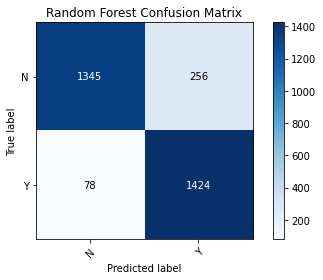

Training Naive Bayes Model



 27%|██▋       | 4/15 [00:10<00:21,  1.99s/it]

----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------



 80%|████████  | 12/15 [00:10<00:01,  2.26it/s]

----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------


100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


----------------------------------------
Naive Bayes Model Results
----------------------------------------
Accuracy Score : 0.7927811795037061
Precision Score : 0.7032654992901088
Recall Score : 0.9893475366178429
F1 Score : 0.8221300138312586
Confusion Matrix : 
[[ 974  627]
 [  16 1486]]


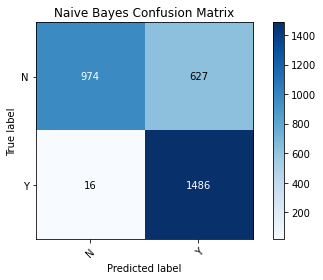

In [10]:
def main():
  
    under_sampled_df = under_sampling(df)
    rf = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=14, max_features='auto',
                                n_estimators=500)
    nb = GaussianNB()
    
    '''
    from sklearn import svm
    clf = svm.SVC(kernel='linear')
    '''

    semi_supervised_learning(under_sampled_df, model=rf, threshold=0.7, iterations=15, algorithm='Random Forest')
    semi_supervised_learning(under_sampled_df, model=nb, threshold=0.7, iterations=15, algorithm='Naive Bayes')


if __name__ == '__main__':
    main()

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import log_loss

# Splitting between train data into training and validation dataset
#X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.20)
# initializing all the model objects with default parameters
model_1 =RandomForestClassifier()
model_2 = GaussianNB()
  
# Making the final model using voting classifier
final_model = VotingClassifier(
    estimators=[('rf', model_1), ('nb', model_2)], voting='hard')